### Normalized Target Variable

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
# import keras_tuner as kt
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.preprocessing.sequence import TimeseriesGenerator
%matplotlib inline

In [4]:
full_data = pd.read_csv("/content/drive/MyDrive/Anti/CPU_616.csv")
full_data = full_data.reset_index(drop=True)
full_data

,Example id,vm_id,cpu_used,diskio_read,diskio_write,created_at
0,24326126,616,0.2%,172301913,345089311,1/1/22 12:00 AM
1,24326382,616,0.2%,172310525,345101743,1/1/22 12:05 AM
2,24326638,616,0.19%,172310525,345106715,1/1/22 12:10 AM
3,24326894,616,0.2%,172310677,345112455,1/1/22 12:15 AM
4,24327150,616,0.2%,172310693,345117407,1/1/22 12:20 AM
...,...,...,...,...,...,...
140348,65165183,616,6.85%,45594927,165928340,5/4/23 3:05 AM
140349,65165493,616,7.43%,45594927,165934556,5/4/23 3:10 AM
140350,65165803,616,7.73%,45594951,165941400,5/4/23 3:15 AM
140351,65166113,616,7.24%,45594983,165948480,5/4/23 3:20 AM


In [5]:
# Converting CPU Usage to Float Datatype

full_data['cpu_used'] = (full_data['cpu_used'].str.replace('%', '').astype(float)) / 100
full_data = full_data[["created_at", "vm_id", "diskio_read", "diskio_write", "cpu_used"]]
full_data

,created_at,vm_id,diskio_read,diskio_write,cpu_used
0,1/1/22 12:00 AM,616,172301913,345089311,0.0020
1,1/1/22 12:05 AM,616,172310525,345101743,0.0020
2,1/1/22 12:10 AM,616,172310525,345106715,0.0019
3,1/1/22 12:15 AM,616,172310677,345112455,0.0020
4,1/1/22 12:20 AM,616,172310693,345117407,0.0020
...,...,...,...,...,...
140348,5/4/23 3:05 AM,616,45594927,165928340,0.0685
140349,5/4/23 3:10 AM,616,45594927,165934556,0.0743
140350,5/4/23 3:15 AM,616,45594951,165941400,0.0773
140351,5/4/23 3:20 AM,616,45594983,165948480,0.0724


In [7]:
full_data['created_at']=pd.to_datetime(full_data['created_at'])

<ipython-input-7-4ce0457b9371>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_data['created_at']=pd.to_datetime(full_data['created_at'])


In [8]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140353 entries, 0 to 140352
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   created_at    140353 non-null  datetime64[ns]
 1   vm_id         140353 non-null  int64         
 2   diskio_read   140353 non-null  int64         
 3   diskio_write  140353 non-null  int64         
 4   cpu_used      140353 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 5.4 MB


In [9]:
full_data.describe().T

,count,mean,std,min,25%,50%,75%,max
vm_id,140353.0,6.160000e+02,0.000000e+00,616.0,6.160000e+02,6.160000e+02,6.160000e+02,6.160000e+02
diskio_read,140353.0,9.383996e+07,6.362811e+07,0.0,3.988372e+07,8.782000e+07,1.413690e+08,2.224585e+08
diskio_write,140353.0,2.694174e+09,2.616029e+09,0.0,1.268198e+08,4.044176e+08,5.413586e+09,5.726768e+09
cpu_used,140353.0,8.315515e-02,5.207521e-02,0.0,6.380000e-02,7.230000e-02,9.850000e-02,1.087800e+00


### Train-Test Split

In [10]:
# Splitting the dataset
x_train, x_test, y_train, y_test = train_test_split(full_data.iloc[:, :-1], full_data.iloc[:, -1], 
                                                    test_size=0.2, shuffle=False)

# Checking dataset splitting result
print(f"Training data: {len(x_train)} data")
print(f"Validation data: {len(x_test)} data")

Training data: 112282 data
Validation data: 28071 data


In [11]:
y_train

0         0.0020
1         0.0020
2         0.0019
3         0.0020
4         0.0020
           ...  
112277    0.0599
112278    0.0574
112279    0.0594
112280    0.0592
112281    0.0592
Name: cpu_used, Length: 112282, dtype: float64

In [12]:
train_dependent_var = y_train.copy()
train_dependent_var[-1] = 0
train_dependent_var.index = train_dependent_var.index + 1
train_dependent_var = train_dependent_var.sort_index()
train_dependent_var = train_dependent_var[:-1]
train_dependent_var

0         0.0000
1         0.0020
2         0.0020
3         0.0019
4         0.0020
           ...  
112277    0.0581
112278    0.0599
112279    0.0574
112280    0.0594
112281    0.0592
Name: cpu_used, Length: 112282, dtype: float64

In [13]:
test_dependent_var = y_test.copy()
test_dependent_var[-1] = 0
test_dependent_var.index = test_dependent_var.index + 1
test_dependent_var = test_dependent_var.sort_index()
test_dependent_var = test_dependent_var[:-1]
test_dependent_var = test_dependent_var.reset_index(drop=True)
test_dependent_var

0        0.0000
1        0.0620
2        0.0581
3        0.0603
4        0.0602
          ...  
28066    0.0765
28067    0.0685
28068    0.0743
28069    0.0773
28070    0.0724
Name: cpu_used, Length: 28071, dtype: float64

In [14]:
# Preparing Data for Time Series Use Case
days_predictors = 1
train_generator = TimeseriesGenerator(x_train, train_dependent_var, length=days_predictors, batch_size=1)
test_generator = TimeseriesGenerator(x_test, test_dependent_var, length=days_predictors, batch_size=1)

In [15]:
for i in range(10):
    x, y = train_generator[i]
    print('%s => %s' % (x, y))

[[[Timestamp('2022-01-01 00:00:00') 616 172301913 345089311]]] => [0.002]
[[[Timestamp('2022-01-01 00:05:00') 616 172310525 345101743]]] => [0.002]
[[[Timestamp('2022-01-01 00:10:00') 616 172310525 345106715]]] => [0.0019]
[[[Timestamp('2022-01-01 00:15:00') 616 172310677 345112455]]] => [0.002]
[[[Timestamp('2022-01-01 00:20:00') 616 172310693 345117407]]] => [0.002]
[[[Timestamp('2022-01-01 00:25:00') 616 172310693 345122979]]] => [0.002]
[[[Timestamp('2022-01-01 00:30:00') 616 172310693 345128559]]] => [0.0019]
[[[Timestamp('2022-01-01 00:35:00') 616 172310693 345134063]]] => [0.0019]
[[[Timestamp('2022-01-01 00:40:00') 616 172310693 345138659]]] => [0.0019]
[[[Timestamp('2022-01-01 00:45:00') 616 172310693 345144131]]] => [0.0018]


In [ ]:
# IRRELEVANT FOR ARIMA
# Processing Training Data
trainx_1d = []
trainy_1d = []

for x, y in train_generator:
    gen_xdata = x.flatten()
    trainx_1d.append(gen_xdata.tolist())  # Append trainx_1d
    trainy_1d.append(y[0])

df_trainx = pd.DataFrame(trainx_1d)
df_trainy = pd.DataFrame(trainy_1d)

# Processing Test Data
testx_1d = []
testy_1d = []
for x, y in test_generator:
    gen_xdata = x.flatten()
    testx_1d.append(gen_xdata.tolist())  # Append testx_1d
    testy_1d.append(y[0])

df_testx = pd.DataFrame(testx_1d)
df_testy = pd.DataFrame(testy_1d)

full_df_x = pd.concat([df_trainx, df_testx], axis=0, ignore_index=True)
full_df_y = pd.concat([df_trainy, df_testy], axis=0, ignore_index=True)
full_df = pd.concat([full_df_x, full_df_y], axis=1, ignore_index=True)

# Normalizing Training Dataset
scaler = MinMaxScaler().fit(full_df_x)
df_train_x = scaler.transform(df_trainx)
df_train_x = pd.DataFrame(df_train_x)
df_train_x.columns = df_trainx.columns

# Normalizing Training Target Variable
target_scaler = MinMaxScaler().fit(full_df_y)
df_train_y = target_scaler.transform(df_trainy)
df_train_y = pd.Series(df_train_y.flatten())

# Normalizing Test Dataset
df_test_x = scaler.transform(df_testx)
df_test_x = pd.DataFrame(df_test_x)
df_test_x.columns = df_testx.columns

# Normalizing Test Target Variable
df_test_y = target_scaler.transform(df_testy)
df_test_y = pd.Series(df_test_y.flatten())

#### Saving Input Data Scaler

In [ ]:
import joblib
joblib.dump(scaler, "BBCA_lags_1_scaler.save") 
joblib.dump(target_scaler, "BBCA_lags_1_target_scaler.save") 

['BBCA_lags_1_target_scaler.save']

In [ ]:
full_train_data = pd.concat([df_train_x, df_train_y], axis=1)
full_train_data.columns = [*full_train_data.columns[:-1], 'Close']
full_train_data

,0,1,2,3,Close
0,0.022105,0.024922,0.022654,0.295404,0.020330
1,0.023158,0.030114,0.024811,0.368339,0.026750
2,0.028421,0.028037,0.024811,0.401741,0.019260
3,0.018947,0.013499,0.016181,0.559497,0.010700
4,0.012632,0.011423,0.014024,0.479711,0.010700
...,...,...,...,...,...
1098,0.545263,0.536272,0.536138,0.500030,0.524598
1099,0.518720,0.513070,0.502697,0.576108,0.515742
1100,0.511579,0.500519,0.491909,0.688142,0.493342
1101,0.484129,0.481791,0.490831,0.461947,0.492202


#### Saving Non-LSTM Input Dataset

In [ ]:
full_train_data.to_csv('BBCA_lags_1_full_train_data.csv', index=False)
df_train_x.to_csv('BBCA_lags_1_df_train_x.csv', index=False)
df_train_y.to_csv('BBCA_lags_1_df_train_y.csv', index=False)
df_test_x.to_csv('BBCA_lags_1_df_test_x.csv', index=False)
df_test_y.to_csv('BBCA_lags_1_df_test_y.csv', index=False)

### Modeling: LSTM Recurrent Neural Network

#### Data Preparation for LSTM Neural Network

In [ ]:
x_train_lstm = df_train_x.to_numpy().reshape(len(df_train_x), 1, len(df_train_x.columns))
x_test_lstm = df_test_x.to_numpy().reshape(len(df_test_x), 1, len(df_test_x.columns))

print(x_train_lstm.shape)

(1103, 1, 4)


#### Saving LSTM Input Dataset

In [ ]:
np.save('BBCA_lags_1_x_train_lstm.npy', x_train_lstm)
np.save('BBCA_lags_1_x_test_lstm.npy', x_test_lstm)

## *Checkpoint Data Preparation

#### Hyperparameter Tuning

In [ ]:
lstm_input_size = x_train_lstm.shape[1:]

def build_model(hp):
    model = keras.Sequential()
    
    model.add(keras.layers.LSTM(units=hp.Int('input_lstm_unit', min_value=10,max_value=40,step=4),
                               input_shape = (lstm_input_size),
                               return_sequences=hp.Choice('return', [True, False]),
                               activation='relu'))
    
#     for i in range(hp.Int('lstm_num_layers', 0, 2)):
#         model.add(keras.layers.LSTM(units=hp.Int('lstm_units_'+str(i), min_value=5, max_value=10, step=1), 
#                                     return_sequences=True,
#                                     activation='relu'))
      
#     model.add(keras.layers.LSTM(units=hp.Int('last_lstm_units', min_value=18,max_value=30,step=1)))
    
    for i in range(hp.Int('dense_num_layers', 1, 3)):
        model.add(keras.layers.Dense(units=hp.Int('dense_units_'+str(i), min_value=10,max_value=22,step=1), activation='relu'))
        
    model.add(keras.layers.Dense(1, activation='linear'))
    
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
                  loss='mean_squared_error',
                  metrics=['mse', 'mape'])
    return model

In [ ]:
tuner = kt.RandomSearch(
            build_model,
            objective='val_mse',
            max_trials=4,
            overwrite=True,
            executions_per_trial=20)

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
input_lstm_unit (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 40, 'step': 4, 'sampling': None}
return (Choice)
{'default': 1, 'conditions': [], 'values': [1, 0], 'ordered': True}
dense_num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': None}
dense_units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 22, 'step': 1, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [ ]:
tuner.search(x_train_lstm, df_train_y, validation_data=(x_test_lstm, df_test_y), epochs=200)

Trial 4 Complete [00h 07m 48s]
val_mse: 9.95870323095005e-05

Best val_mse So Far: 9.95870323095005e-05
Total elapsed time: 00h 32m 55s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.results_summary()

Results summary
Results in .\untitled_project
Showing 10 best trials
Objective(name='val_mse', direction='min')
Trial summary
Hyperparameters:
input_lstm_unit: 18
return: 0
dense_num_layers: 2
dense_units_0: 18
learning_rate: 0.01
dense_units_1: 21
dense_units_2: 12
Score: 9.95870323095005e-05
Trial summary
Hyperparameters:
input_lstm_unit: 26
return: 1
dense_num_layers: 1
dense_units_0: 20
learning_rate: 0.001
dense_units_1: 21
dense_units_2: 17
Score: 0.00010595063758955803
Trial summary
Hyperparameters:
input_lstm_unit: 18
return: 0
dense_num_layers: 3
dense_units_0: 12
learning_rate: 0.001
dense_units_1: 10
dense_units_2: 10
Score: 0.0001080578273104038
Trial summary
Hyperparameters:
input_lstm_unit: 30
return: 1
dense_num_layers: 3
dense_units_0: 14
learning_rate: 0.0001
dense_units_1: 19
dense_units_2: 18
Score: 0.00012235795074957422


#### Model Evaluation

In [ ]:
# Define model
model = tf.keras.Sequential([
        tf.keras.layers.LSTM(100, input_shape = (x_train_lstm.shape[1:]), return_sequences=True, activation="relu"),
        tf.keras.layers.LSTM(40, return_sequences=True, activation="relu"),
#         tf.keras.layers.LSTM(9, return_sequences=True, activation="relu"),
#         tf.keras.layers.LSTM(24),
#         tf.keras.layers.Dense(18, activation="relu"),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dense(1, activation='linear')
])

# Setting up the model optimizer and loss function
model.compile(loss='mae', 
              optimizer=keras.optimizers.Adam(learning_rate=0.001), 
              metrics=['mse','mae', tf.keras.metrics.RootMeanSquaredError()])

# Implementing Callbacks
val_threshold = 0.00001
class myCallback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('val_mse') <= val_threshold): 
            self.model.stop_training = True
                        
callback_1 = myCallback()
callback_2 = tf.keras.callbacks.EarlyStopping(monitor='val_mse', patience=10, restore_best_weights=True)

# Model Fitting
history_lstm = model.fit(x=x_train_lstm, 
                         y=df_train_y, 
                         validation_data = (x_test_lstm, df_test_y),
                         epochs=1000, 
                         callbacks=[callback_2],
                         verbose=2)

Epoch 1/1000
35/35 - 3s - loss: 0.3277 - mse: 0.1667 - mae: 0.3277 - root_mean_squared_error: 0.4082 - val_loss: 0.5028 - val_mse: 0.2615 - val_mae: 0.5028 - val_root_mean_squared_error: 0.5114
Epoch 2/1000
35/35 - 0s - loss: 0.1422 - mse: 0.0319 - mae: 0.1422 - root_mean_squared_error: 0.1787 - val_loss: 0.0835 - val_mse: 0.0076 - val_mae: 0.0835 - val_root_mean_squared_error: 0.0870
Epoch 3/1000
35/35 - 0s - loss: 0.0486 - mse: 0.0046 - mae: 0.0486 - root_mean_squared_error: 0.0676 - val_loss: 0.0581 - val_mse: 0.0053 - val_mae: 0.0581 - val_root_mean_squared_error: 0.0725
Epoch 4/1000
35/35 - 0s - loss: 0.0217 - mse: 8.7136e-04 - mae: 0.0217 - root_mean_squared_error: 0.0295 - val_loss: 0.0407 - val_mse: 0.0026 - val_mae: 0.0407 - val_root_mean_squared_error: 0.0507
Epoch 5/1000
35/35 - 0s - loss: 0.0118 - mse: 2.5746e-04 - mae: 0.0118 - root_mean_squared_error: 0.0160 - val_loss: 0.0270 - val_mse: 0.0012 - val_mae: 0.0270 - val_root_mean_squared_error: 0.0345
Epoch 6/1000
35/35 - 0

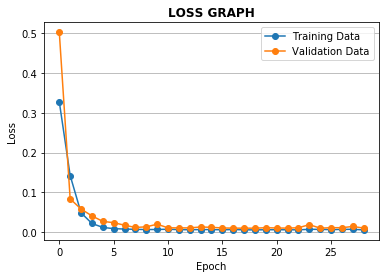

In [ ]:
# Plot training and validation loss during learning process
import matplotlib.pyplot as plt

plt.plot(history_lstm.history["loss"], marker="o", label="Training Data")
plt.plot(history_lstm.history["val_loss"], marker="o", label="Validation Data")
plt.title("LOSS GRAPH", weight="bold")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(b=1, axis="y")
plt.legend()

plt.show()

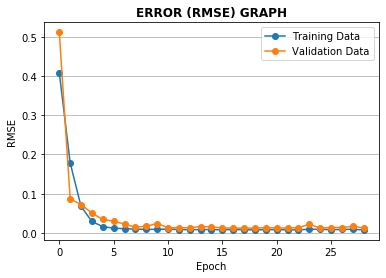

In [ ]:
# Plot training and validation error during learning process
import matplotlib.pyplot as plt

plt.plot(history_lstm.history["root_mean_squared_error"], marker="o", label="Training Data")
plt.plot(history_lstm.history["val_root_mean_squared_error"], marker="o", label="Validation Data")
plt.title("ERROR (RMSE) GRAPH", weight="bold")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.grid(b=1, axis="y")
plt.legend()

plt.show()

### Modeling: Single Layer Perceptron

In [ ]:
def build_model(hp):
    model = keras.Sequential()
    
    model.add(keras.layers.Dense(units=hp.Choice('dense_units_'+str(i), [128,256,512,1024,2048]), 
                                 activation=hp.Choice('activation', ['relu', 'tanh'])))
    model.add(keras.layers.Dense(1, activation='linear'))
    
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
                  loss=hp.Choice('loss function', ['mean_squared_error', 'mean_absolute_error']),
                  metrics=['mae', 'mse'])
    return model

In [ ]:
tuner = kt.RandomSearch(
            build_model,
            objective='val_mse',
            max_trials=3,
            overwrite=True,
            executions_per_trial=15)

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
dense_units_178 (Choice)
{'default': 128, 'conditions': [], 'values': [128, 256, 512, 1024, 2048], 'ordered': True}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
loss function (Choice)
{'default': 'mean_squared_error', 'conditions': [], 'values': ['mean_squared_error', 'mean_absolute_error'], 'ordered': False}


In [ ]:
tuner.search(df_train_x, df_train_y, validation_data=(df_test_x, df_test_y), epochs=200)

Trial 3 Complete [00h 02m 21s]
val_mse: 0.024572853371500968

Best val_mse So Far: 0.02354110168914
Total elapsed time: 00h 07m 28s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.results_summary()

Results summary
Results in .\untitled_project
Showing 10 best trials
Objective(name='val_mse', direction='min')
Trial summary
Hyperparameters:
dense_units_178: 1024
activation: relu
learning_rate: 0.001
loss function: mean_absolute_error
Score: 0.02354110168914
Trial summary
Hyperparameters:
dense_units_178: 128
activation: tanh
learning_rate: 0.01
loss function: mean_squared_error
Score: 0.024572853371500968
Trial summary
Hyperparameters:
dense_units_178: 1024
activation: tanh
learning_rate: 0.001
loss function: mean_absolute_error
Score: 0.04568939010302226


In [ ]:
# Implementing Callbacks
class myCallback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('val_mse') <= val_threshold): 
            self.model.stop_training = True
                        
callback_1 = myCallback()
callback_2 = tf.keras.callbacks.EarlyStopping(monitor='val_mse', patience=3, restore_best_weights=True)

# Define model
model = tf.keras.Sequential([
        tf.keras.layers.Dense(1024, activation="relu"),
        tf.keras.layers.Dense(1)
])

# Setting up the model optimizer and loss function
model.compile(loss='mae', 
              optimizer=keras.optimizers.Adam(learning_rate=0.001), 
              metrics=['mse', 'mae', tf.keras.metrics.RootMeanSquaredError()])

# fit model
history_single = model.fit(x = df_train_x, 
                    y = df_train_y, 
                    validation_data = (df_test_x, df_test_y),
                    epochs=1000, 
                    callbacks=[callback_2],
                    verbose=2)

Epoch 1/1000
35/35 - 1s - loss: 0.0986 - mse: 0.0302 - mae: 0.0986 - root_mean_squared_error: 0.1739 - val_loss: 0.0563 - val_mse: 0.0035 - val_mae: 0.0563 - val_root_mean_squared_error: 0.0588
Epoch 2/1000
35/35 - 0s - loss: 0.0121 - mse: 2.6017e-04 - mae: 0.0121 - root_mean_squared_error: 0.0161 - val_loss: 0.0114 - val_mse: 1.9800e-04 - val_mae: 0.0114 - val_root_mean_squared_error: 0.0141
Epoch 3/1000
35/35 - 0s - loss: 0.0062 - mse: 7.4247e-05 - mae: 0.0062 - root_mean_squared_error: 0.0086 - val_loss: 0.0128 - val_mse: 2.4964e-04 - val_mae: 0.0128 - val_root_mean_squared_error: 0.0158
Epoch 4/1000
35/35 - 0s - loss: 0.0060 - mse: 7.1761e-05 - mae: 0.0060 - root_mean_squared_error: 0.0085 - val_loss: 0.0093 - val_mse: 1.3472e-04 - val_mae: 0.0093 - val_root_mean_squared_error: 0.0116
Epoch 5/1000
35/35 - 0s - loss: 0.0066 - mse: 8.3262e-05 - mae: 0.0066 - root_mean_squared_error: 0.0091 - val_loss: 0.0103 - val_mse: 1.6596e-04 - val_mae: 0.0103 - val_root_mean_squared_error: 0.012

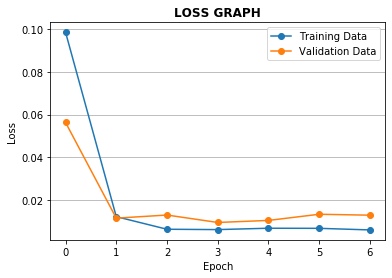

In [ ]:
# Plot training and validation loss during learning process
import matplotlib.pyplot as plt

plt.plot(history_single.history["loss"], marker="o", label="Training Data")
plt.plot(history_single.history["val_loss"], marker="o", label="Validation Data")
plt.title("LOSS GRAPH", weight="bold")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(b=1, axis="y")
plt.legend()

plt.show()

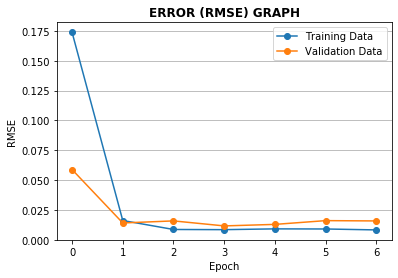

In [ ]:
# Plot training and validation error during learning process
import matplotlib.pyplot as plt

plt.plot(history_single.history["root_mean_squared_error"], marker="o", label="Training Data")
plt.plot(history_single.history["val_root_mean_squared_error"], marker="o", label="Validation Data")
plt.title("ERROR (RMSE) GRAPH", weight="bold")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.grid(b=1, axis="y")
plt.legend()

plt.show()

### Modeling: Multiple Layers Neural Network

In [ ]:
def build_model(hp):
    model = keras.Sequential()
    for i in range(hp.Int('dense_layers_num', 1, 7)):
        model.add(keras.layers.Dense(units=hp.Choice('dense_units_'+str(i), [16,32,64,128,256,512]), activation='relu'))
    model.add(keras.layers.Dense(1, activation='linear'))
    
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
                  loss=hp.Choice('loss_function', ['mean_squared_error', 'mean_absolute_error']),
                  metrics=['mae', 'mse'])
    return model

In [ ]:
tuner = kt.RandomSearch(
            build_model,
            objective='val_mse',
            max_trials=5,
            overwrite=True,
            executions_per_trial=5)

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
dense_layers_num (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 7, 'step': 1, 'sampling': None}
dense_units_0 (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64, 128, 256, 512], 'ordered': True}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
activation_function (Choice)
{'default': 'mean_squared_error', 'conditions': [], 'values': ['mean_squared_error', 'mean_absolute_error'], 'ordered': False}


In [ ]:
tuner.search(df_train_x, df_train_y, validation_data=(df_test_x, df_test_y), epochs=100)

Trial 5 Complete [00h 00m 32s]
val_mse: 0.020789726823568343

Best val_mse So Far: 0.017999172024428845
Total elapsed time: 00h 03m 01s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.results_summary()

Results summary
Results in .\untitled_project
Showing 10 best trials
Objective(name='val_mse', direction='min')
Trial summary
Hyperparameters:
dense_layers_num: 7
dense_units_0: 256
learning_rate: 0.01
activation_function: mean_absolute_error
dense_units_1: 16
dense_units_2: 16
dense_units_3: 16
dense_units_4: 16
dense_units_5: 16
dense_units_6: 16
Score: 0.017999172024428845
Trial summary
Hyperparameters:
dense_layers_num: 3
dense_units_0: 64
learning_rate: 0.001
activation_function: mean_squared_error
dense_units_1: 16
dense_units_2: 128
dense_units_3: 16
dense_units_4: 128
dense_units_5: 16
dense_units_6: 64
Score: 0.020789726823568343
Trial summary
Hyperparameters:
dense_layers_num: 2
dense_units_0: 256
learning_rate: 0.0001
activation_function: mean_absolute_error
dense_units_1: 512
dense_units_2: 128
dense_units_3: 16
dense_units_4: 16
dense_units_5: 512
dense_units_6: 64
Score: 0.02776411548256874
Trial summary
Hyperparameters:
dense_layers_num: 2
dense_units_0: 16
learning_rate

In [ ]:
# Implementing Callbacks
class myCallback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('val_mse') <= val_threshold): 
            self.model.stop_training = True
                        
callback_1 = myCallback()
callback_2 = tf.keras.callbacks.EarlyStopping(monitor='val_mse', patience=20, restore_best_weights=True)

# Define model
model = tf.keras.Sequential([
        tf.keras.layers.Dense(1024, activation="relu"),
#         tf.keras.layers.Dropout(0.2),
#         tf.keras.layers.Dense(16, activation="relu"),
#         tf.keras.layers.Dropout(0.2),
#         tf.keras.layers.Dense(16, activation="relu"),
#         tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(16, activation="relu"),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dense(1)
])


# Setting up the model optimizer and loss function
model.compile(loss='mae', 
              optimizer=keras.optimizers.Adam(learning_rate=0.001), 
              metrics=['mse', 'mae', tf.keras.metrics.RootMeanSquaredError()])

# fit model
history_multiple = model.fit(x = df_train_x, 
                    y = df_train_y, 
                    validation_data = (df_test_x, df_test_y),
                    epochs=1000, 
                    callbacks=[callback_2],
                    verbose=2)

Epoch 1/1000
35/35 - 1s - loss: 0.0901 - mse: 0.0262 - mae: 0.0901 - root_mean_squared_error: 0.1620 - val_loss: 0.0344 - val_mse: 0.0014 - val_mae: 0.0344 - val_root_mean_squared_error: 0.0369
Epoch 2/1000
35/35 - 0s - loss: 0.0091 - mse: 1.4460e-04 - mae: 0.0091 - root_mean_squared_error: 0.0120 - val_loss: 0.0104 - val_mse: 1.7754e-04 - val_mae: 0.0104 - val_root_mean_squared_error: 0.0133
Epoch 3/1000
35/35 - 0s - loss: 0.0069 - mse: 8.5665e-05 - mae: 0.0069 - root_mean_squared_error: 0.0093 - val_loss: 0.0092 - val_mse: 1.3280e-04 - val_mae: 0.0092 - val_root_mean_squared_error: 0.0115
Epoch 4/1000
35/35 - 0s - loss: 0.0065 - mse: 8.1760e-05 - mae: 0.0065 - root_mean_squared_error: 0.0090 - val_loss: 0.0105 - val_mse: 1.6643e-04 - val_mae: 0.0105 - val_root_mean_squared_error: 0.0129
Epoch 5/1000
35/35 - 0s - loss: 0.0073 - mse: 9.7565e-05 - mae: 0.0073 - root_mean_squared_error: 0.0099 - val_loss: 0.0159 - val_mse: 3.5774e-04 - val_mae: 0.0159 - val_root_mean_squared_error: 0.018

Epoch 42/1000
35/35 - 0s - loss: 0.0053 - mse: 5.7036e-05 - mae: 0.0053 - root_mean_squared_error: 0.0076 - val_loss: 0.0114 - val_mse: 2.0687e-04 - val_mae: 0.0114 - val_root_mean_squared_error: 0.0144
Epoch 43/1000
35/35 - 0s - loss: 0.0058 - mse: 6.6976e-05 - mae: 0.0058 - root_mean_squared_error: 0.0082 - val_loss: 0.0116 - val_mse: 1.9446e-04 - val_mae: 0.0116 - val_root_mean_squared_error: 0.0139
Epoch 44/1000
35/35 - 0s - loss: 0.0075 - mse: 9.8957e-05 - mae: 0.0075 - root_mean_squared_error: 0.0099 - val_loss: 0.0097 - val_mse: 1.4598e-04 - val_mae: 0.0097 - val_root_mean_squared_error: 0.0121
Epoch 45/1000
35/35 - 0s - loss: 0.0068 - mse: 8.1856e-05 - mae: 0.0068 - root_mean_squared_error: 0.0090 - val_loss: 0.0096 - val_mse: 1.4758e-04 - val_mae: 0.0096 - val_root_mean_squared_error: 0.0121
Epoch 46/1000
35/35 - 0s - loss: 0.0060 - mse: 7.3175e-05 - mae: 0.0060 - root_mean_squared_error: 0.0086 - val_loss: 0.0125 - val_mse: 2.2544e-04 - val_mae: 0.0125 - val_root_mean_squared

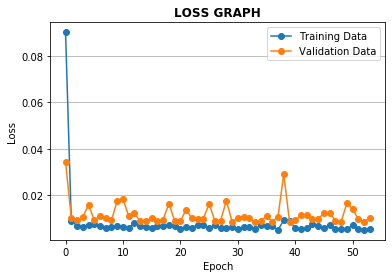

In [ ]:
# Plot training and validation loss during learning process
import matplotlib.pyplot as plt

plt.plot(history_multiple.history["loss"], marker="o", label="Training Data")
plt.plot(history_multiple.history["val_loss"], marker="o", label="Validation Data")
plt.title("LOSS GRAPH", weight="bold")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(b=1, axis="y")
plt.legend()

plt.show()

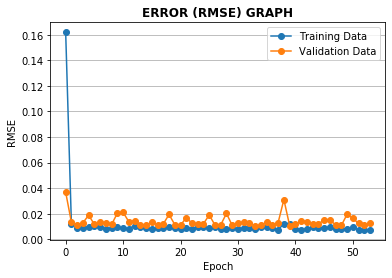

In [ ]:
# Plot training and validation error during learning process
import matplotlib.pyplot as plt

plt.plot(history_multiple.history["root_mean_squared_error"], marker="o", label="Training Data")
plt.plot(history_multiple.history["val_root_mean_squared_error"], marker="o", label="Validation Data")
plt.title("ERROR (RMSE) GRAPH", weight="bold")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.grid(b=1, axis="y")
plt.legend()

plt.show()

### Modeling: Bidirectional Recurrent Neural Network

In [ ]:
lstm_input_size = x_train_lstm.shape[1:]

def build_model(hp):
    model = keras.Sequential()
    
    model.add(keras.layers.Bidirectional(LSTM(units=hp.Int('input_lstm_unit', min_value=16,max_value=40,step=4),
                               input_shape = (lstm_input_size),
                               return_sequences=True,
                               activation='relu')))
    
    for i in range(hp.Int('lstm_num_layers', 0, 3)):
        model.add(keras.layers.Bidirectional(LSTM(units=hp.Int('lstm_units_'+str(i), min_value=16,max_value=40,step=4), 
                                    return_sequences=True,
                                    activation='relu')))
      
    model.add(keras.layers.Bidirectional(LSTM(units=hp.Int('last_lstm_units', min_value=16,max_value=40,step=4))))
    
    for i in range(hp.Int('dense_num_layers', 1, 3)):
        model.add(keras.layers.Dense(units=hp.Int('dense_units_'+str(i), min_value=10,max_value=30,step=1), activation='relu'))
        
    model.add(keras.layers.Dense(1, activation='linear'))
    
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
                  loss=hp.Choice('loss_function',['mean_squared_error', 'mean_absolute_error']),
                  metrics=['mse', tf.keras.metrics.RootMeanSquaredError()])
    return model

In [ ]:
tuner = kt.RandomSearch(
            build_model,
            objective='val_mse',
            max_trials=6,
            overwrite=True,
            executions_per_trial=10)

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 7
input_lstm_unit (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 40, 'step': 4, 'sampling': None}
lstm_num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 0, 'max_value': 3, 'step': 1, 'sampling': None}
last_lstm_units (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 40, 'step': 4, 'sampling': None}
dense_num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': None}
dense_units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 30, 'step': 1, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
loss_function (Choice)
{'default': 'mean_squared_error', 'conditions': [], 'values': ['mean_squared_error', 'mean_absolute_error'], 'ordered': False}


In [ ]:
tuner.search(x_train_lstm, df_train_y, validation_data=(x_test_lstm, df_test_y), epochs=200)

Trial 6 Complete [00h 05m 17s]
val_mse: 0.017607640009373426

Best val_mse So Far: 0.009902892261743545
Total elapsed time: 00h 29m 43s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.results_summary()

Results summary
Results in .\untitled_project
Showing 10 best trials
Objective(name='val_mse', direction='min')
Trial summary
Hyperparameters:
input_lstm_unit: 24
lstm_num_layers: 2
last_lstm_units: 36
dense_num_layers: 3
dense_units_0: 14
learning_rate: 0.01
loss_function: mean_absolute_error
lstm_units_0: 24
lstm_units_1: 16
lstm_units_2: 20
dense_units_1: 23
dense_units_2: 10
Score: 0.009902892261743545
Trial summary
Hyperparameters:
input_lstm_unit: 16
lstm_num_layers: 2
last_lstm_units: 24
dense_num_layers: 2
dense_units_0: 29
learning_rate: 0.01
loss_function: mean_absolute_error
lstm_units_0: 32
lstm_units_1: 28
lstm_units_2: 16
dense_units_1: 17
Score: 0.010078280419111251
Trial summary
Hyperparameters:
input_lstm_unit: 24
lstm_num_layers: 2
last_lstm_units: 36
dense_num_layers: 1
dense_units_0: 29
learning_rate: 0.001
loss_function: mean_absolute_error
lstm_units_0: 36
lstm_units_1: 16
lstm_units_2: 20
dense_units_1: 28
dense_units_2: 25
Score: 0.017607640009373426
Trial summa

In [ ]:
# Implementing Callbacks
class myCallback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('val_mse') <= val_threshold): 
            self.model.stop_training = True
                        
callback_1 = myCallback()
callback_2 = tf.keras.callbacks.EarlyStopping(monitor='val_mse', patience=10, restore_best_weights=True)


# define model
lstm_input_size = x_train_lstm.shape[1:]
model = tf.keras.Sequential([
        tf.keras.layers.Bidirectional(LSTM(24, input_shape = (lstm_input_size), return_sequences=True, activation='relu')),
        tf.keras.layers.Bidirectional(LSTM(24, return_sequences=True, activation='relu')),
#         tf.keras.layers.Bidirectional(LSTM(16, return_sequences=True, activation='relu')),
#         tf.keras.layers.Bidirectional(LSTM(36, activation='relu')),
#         tf.keras.layers.Dense(14, activation="relu"),
        tf.keras.layers.Dense(10, activation="relu"),
        tf.keras.layers.Dense(1)
])

# Setting up the model optimizer and loss function
model.compile(loss='mae', 
              optimizer=keras.optimizers.Adam(learning_rate=0.001), 
              metrics=['mse', 'mae', tf.keras.metrics.RootMeanSquaredError()])

# fit model
history_bidir = model.fit(x=x_train_lstm, 
                    y=df_train_y, 
                    validation_data = (x_test_lstm, df_test_y),
                    epochs=1000, 
                    callbacks=[callback_2],
                    verbose=2)

Epoch 1/1000
35/35 - 6s - loss: 0.3382 - mse: 0.1760 - mae: 0.3382 - root_mean_squared_error: 0.4196 - val_loss: 0.5913 - val_mse: 0.3599 - val_mae: 0.5913 - val_root_mean_squared_error: 0.5999
Epoch 2/1000
35/35 - 0s - loss: 0.2022 - mse: 0.0629 - mae: 0.2022 - root_mean_squared_error: 0.2509 - val_loss: 0.0747 - val_mse: 0.0069 - val_mae: 0.0747 - val_root_mean_squared_error: 0.0829
Epoch 3/1000
35/35 - 0s - loss: 0.0857 - mse: 0.0134 - mae: 0.0857 - root_mean_squared_error: 0.1159 - val_loss: 0.0416 - val_mse: 0.0029 - val_mae: 0.0416 - val_root_mean_squared_error: 0.0542
Epoch 4/1000
35/35 - 0s - loss: 0.0311 - mse: 0.0017 - mae: 0.0311 - root_mean_squared_error: 0.0413 - val_loss: 0.0414 - val_mse: 0.0028 - val_mae: 0.0414 - val_root_mean_squared_error: 0.0532
Epoch 5/1000
35/35 - 0s - loss: 0.0168 - mse: 5.3391e-04 - mae: 0.0168 - root_mean_squared_error: 0.0231 - val_loss: 0.0234 - val_mse: 9.9911e-04 - val_mae: 0.0234 - val_root_mean_squared_error: 0.0316
Epoch 6/1000
35/35 - 0

Epoch 42/1000
35/35 - 0s - loss: 0.0053 - mse: 5.9377e-05 - mae: 0.0053 - root_mean_squared_error: 0.0077 - val_loss: 0.0097 - val_mse: 1.5275e-04 - val_mae: 0.0097 - val_root_mean_squared_error: 0.0124


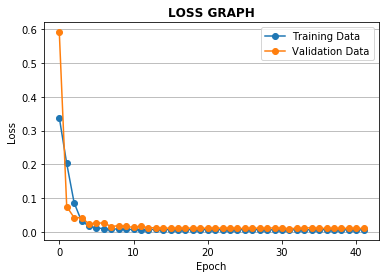

In [ ]:
# Plot training and validation loss during learning process
import matplotlib.pyplot as plt

plt.plot(history_bidir.history["loss"], marker="o", label="Training Data")
plt.plot(history_bidir.history["val_loss"], marker="o", label="Validation Data")
plt.title("LOSS GRAPH", weight="bold")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(b=1, axis="y")
plt.legend()

plt.show()

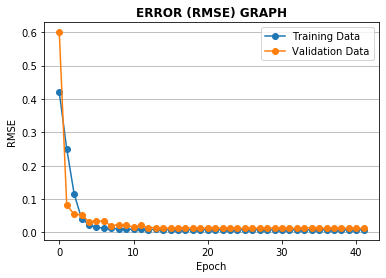

In [ ]:
# Plot training and validation error during learning process
import matplotlib.pyplot as plt

plt.plot(history_bidir.history["root_mean_squared_error"], marker="o", label="Training Data")
plt.plot(history_bidir.history["val_root_mean_squared_error"], marker="o", label="Validation Data")
plt.title("ERROR (RMSE) GRAPH", weight="bold")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.grid(b=1, axis="y")
plt.legend()

plt.show()

### Modeling: ARIMA Univariate Time Series Forecasting

#### Visualizing Preprocessed CPU Usage Variable

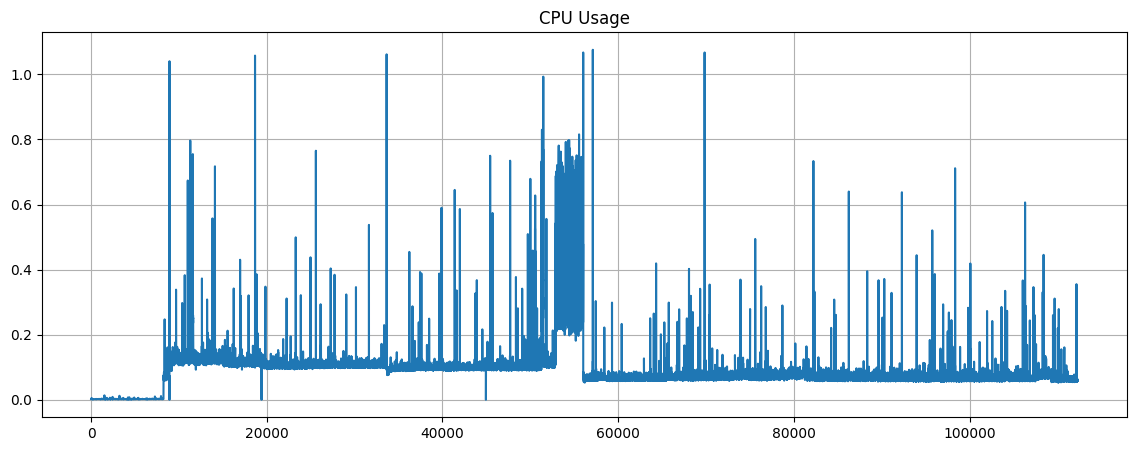

In [16]:
fig, (ax1) = plt.subplots(1,figsize=(14,5))
plt.title('CPU Usage')
ax1.plot(y_train.index.to_numpy(), y_train)
plt.grid()

#### Stationarity Test

In [17]:
from statsmodels.tsa.stattools import adfuller

def adfullertest(data):
    result = adfuller(data)
    print(f'ADF Statistics: {result[0]}')
    print(f'p-Value: {result[1]}')
    if result[1] < 0.05:
        print('Stationary')
    else:
        print('Non-Stationary')

Augmented Dickey-Fuller (ADF test) merupakan pengujian statistik untuk mengukur stationarity data. Pengujian ini memiliki hipotesis nol (H0) bahwa data tidak stasioner. Umumnya jika p-value < 0.05, maka dianggap telah cukup bukti untuk menolak H0 dan menerima H1 bahwa data telah memiliki sifat stasioner.

In [18]:
adfullertest(y_train)

ADF Statistics: -6.152189010007072
p-Value: 7.515677911141271e-08
Stationary


Hasil ADF Test menunjukkan p-value > 0.05. Dari nilai ini dapat ditarik kesimpulan bahwa data masih sangat jauh dari sifat stasioner untuk dapat dijadikan sebagai input ARIMA. Untuk itu, akan digunakan teknik differencing untuk menghilangkan trend dari data dan sekaligus membuat data menjadi lebih stasioner.

#### Differencing Technique

In [20]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA

#### Data Asli

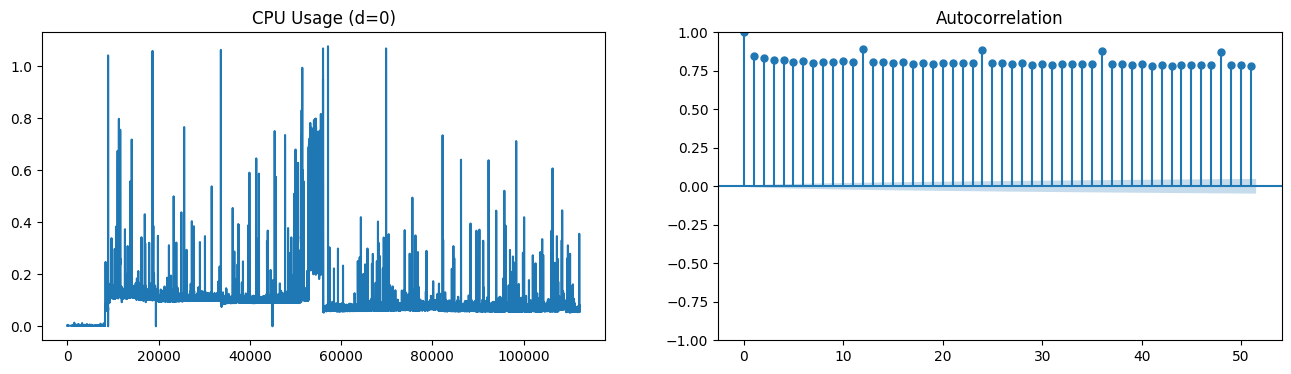

In [21]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,4))
ax1.plot(y_train)
ax1.set_title('CPU Usage (d=0)')
plot_acf(y_train, ax=ax2);

Dari visualisasi, mudah terlihat bahwa data asli masih jauh dari sifat stasioner.

#### First Order Differencing (d=1)

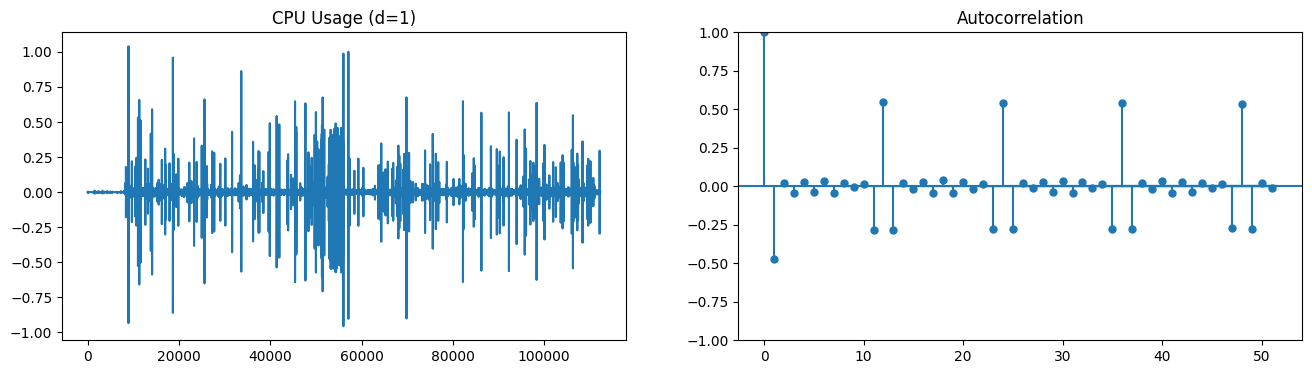

In [ ]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,4))
ax1.plot(y_train.diff().dropna())
ax1.set_title('CPU Usage (d=1)')
plot_acf(y_train.diff().dropna(), ax=ax2);

Penggunaan teknik differencing sebanyak satu kali terlihat telah berhasil menekan trend dari data dan membuat data menjadi lebih stabil. Selanjutnya dapat diperiksa penggunaan differencing sebanyak dua kali untuk melihat apakah ada perbaikan lebih lanjut yang signifikan.

#### Second Order Differencing (d=2)

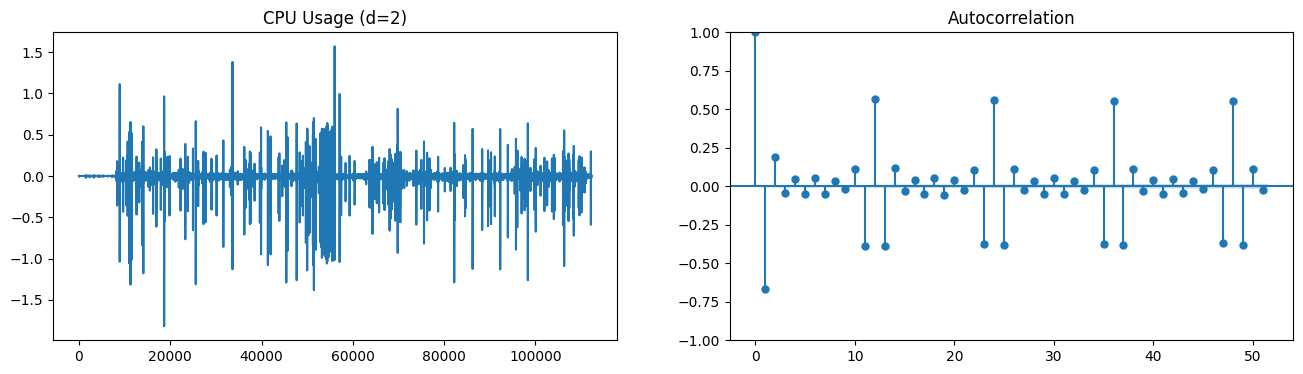

In [ ]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,4))
ax1.plot(y_train.diff().diff().dropna())
ax1.set_title('CPU Usage (d=2)')
plot_acf(y_train.diff().diff().dropna(), ax=ax2);

#### Autoregression (AR) Parameter

Parameter Autoregression (p) pada ARIMA merupakan jumlah lags yang digunakan ARIMA untuk melakukan prediksi. Dengan kata lain, parameter ini menunjukkan seberapa jauh ARIMA akan meihat past values untuk melakukan prediksi terhadap data baru. Untuk menentukannya dapat digunakan analisis Partial Autocorrelation Function (PACF).

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


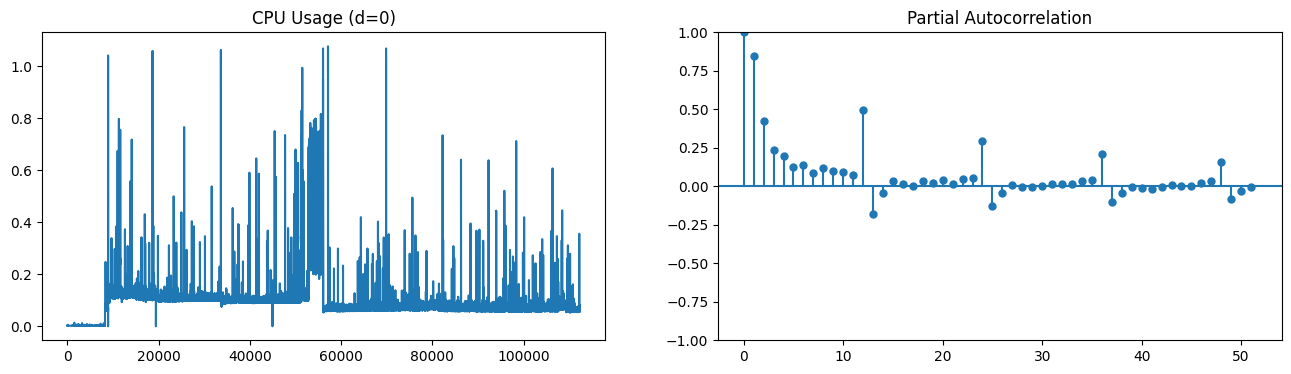

In [ ]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,4))
ax1.plot(y_train.dropna())
ax1.set_title('CPU Usage (d=0)')
plot_pacf(y_train.dropna(), ax=ax2);

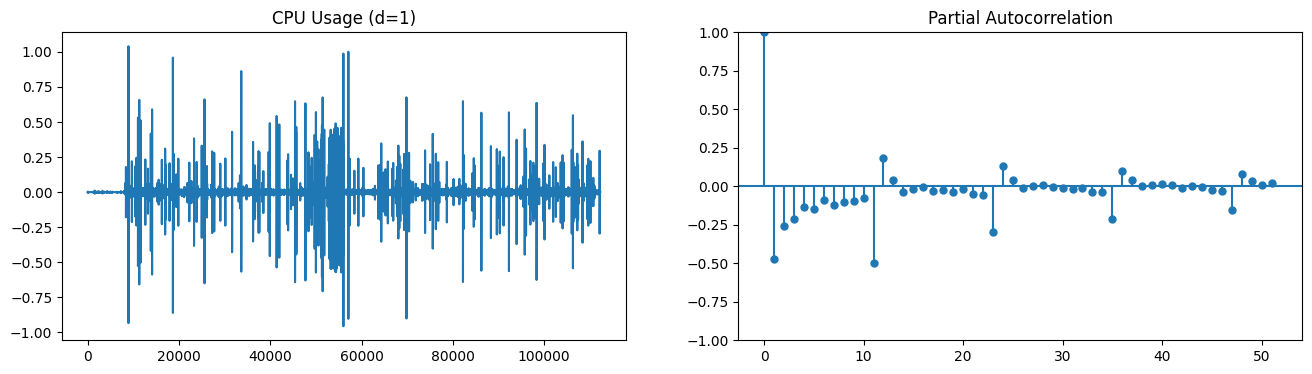

In [ ]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,4))
ax1.plot(y_train.diff().dropna())
ax1.set_title('CPU Usage (d=1)')
plot_pacf(y_train.diff().dropna(), ax=ax2);

#### Moving Average (MA) Parameter

Parameter Moving Average (q) pada ARIMA menunjukkan seberapa jauh error lags yang dipertimbangkan untuk melakukan prediksi. Parameter ini dapat ditentukan dengan menggunakan analisis Autocorrelation Function (ACF).

NameError: ignored

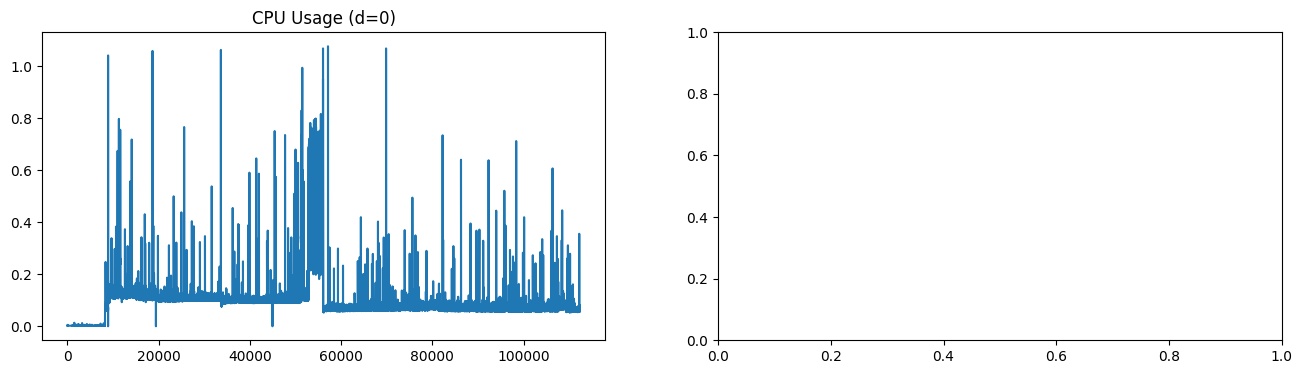

In [19]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,4))
ax1.plot(y_train.dropna())
ax1.set_title('CPU Usage (d=0)')
plot_acf(y_train.dropna(), ax=ax2);

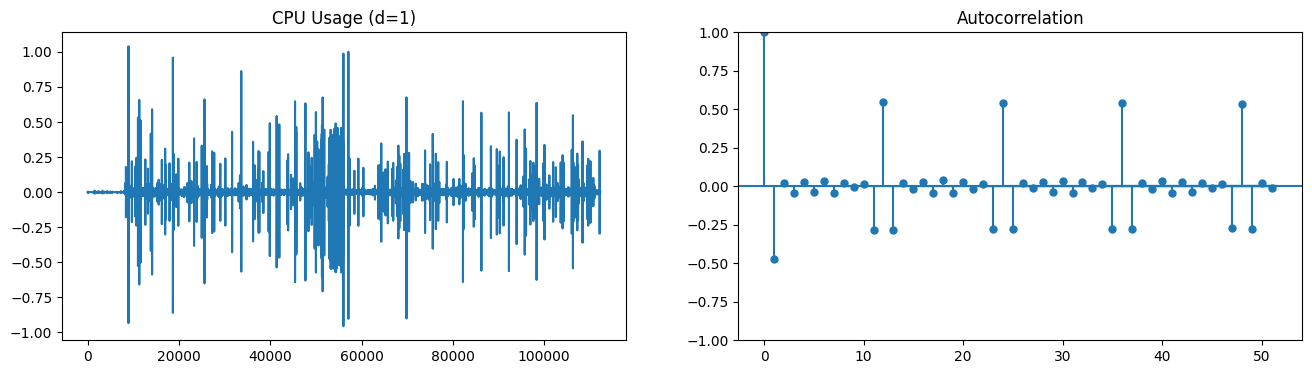

In [ ]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,4))
ax1.plot(y_train.diff().dropna())
ax1.set_title('CPU Usage (d=1)')
plot_acf(y_train.diff().dropna(), ax=ax2);

### ARIMA Model Hyperparameter Tuning

In [22]:
# Model Evaluation Functions
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# Evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(df_train_y, df_test_y, arima_order):
    # Prepare training dataset
    train_size = int(len(df_train_y))
    test_size = int(len(df_test_y))
    train, test = df_train_y, df_test_y
    # Make predictions
    model = ARIMA(df_train_y, order=arima_order)
    model_fit = model.fit()
    predictions = model_fit.forecast(test_size)
    # Calculate out of sample error
    rmse = (mean_squared_error(test, predictions))**0.5
    mae = mean_absolute_error(test, predictions)
    return rmse, mae
 
# Evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(df_train_y, df_test_y, p_values, d_values, q_values):
    best_score, best_cfg, best_mae = float("inf"), None, float("inf")
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse, mae = evaluate_arima_model(df_train_y, df_test_y, order)
                    if rmse < best_score:
                        best_score, best_cfg, best_mae = rmse, order, mae
                    print('ARIMA%s RMSE=%.3f MAE=%.3f' % (order,rmse,mae))
                except:
                    continue
    print('Best ARIMA %s RMSE = %.3f MAE = %.3f' % (best_cfg, best_score, best_mae))

In [23]:
# HATI-HATI LAMA

import warnings
warnings.filterwarnings("ignore")

# Evaluate parameters
p_values = [1, 2]
d_values = [0, 1]
q_values = [1, 2]

evaluate_models(y_train, y_test, p_values, d_values, q_values)

ARIMA(1, 0, 1) RMSE=0.028 MAE=0.019
ARIMA(1, 0, 2) RMSE=0.029 MAE=0.020
ARIMA(1, 1, 1) RMSE=0.024 MAE=0.010
ARIMA(1, 1, 2) RMSE=0.024 MAE=0.010
ARIMA(2, 0, 1) RMSE=0.025 MAE=0.013
ARIMA(2, 0, 2) RMSE=0.054 MAE=0.050
ARIMA(2, 1, 1) RMSE=0.024 MAE=0.010
ARIMA(2, 1, 2) RMSE=0.024 MAE=0.010
Best ARIMA (1, 1, 2) RMSE = 0.024 MAE = 0.010


#### Forecasting Future Values of CPU Usage

In [34]:
prediction_days=1
model = ARIMA(y_train, order=(1,1,2))
model_fit = model.fit()
predictions = model_fit.forecast(prediction_days * 24)
predictions = pd.DataFrame(predictions)

fitting = model_fit.predict(start=1, end=len(y_train))
predictions.columns = ['CPU USage']
predictions

,CPU USage
112282,0.059985
112283,0.057932
112284,0.059983
112285,0.057934
112286,0.059981
112287,0.057935
112288,0.059980
112289,0.057937
112290,0.059978
112291,0.057939


#### Visualizing Back-Normalized Forecasted Values

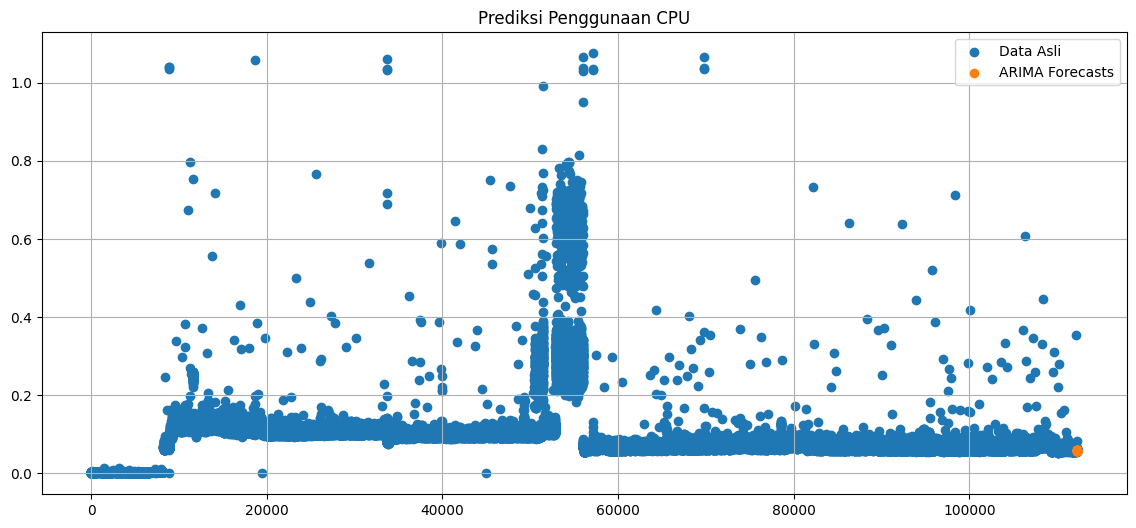

In [36]:
fig, ax = plt.subplots(1,1,figsize=(14,6))

ax.scatter(np.arange(1,len(y_train)+1,1), 
           y_train[:len(y_train)], 
           label='Data Asli')

ax.scatter(np.arange(len(y_train),len(y_train)+(prediction_days * 24),1), 
           predictions, 
           label='ARIMA Forecasts')

plt.title('Prediksi Penggunaan CPU')
plt.grid()
plt.legend()

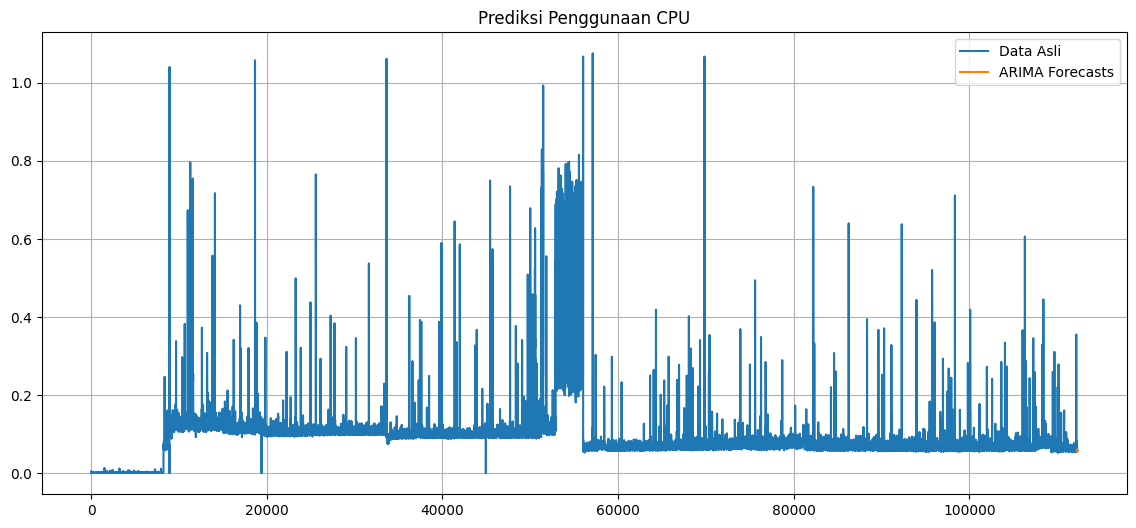

In [37]:
fig, ax = plt.subplots(1,1,figsize=(14,6))

ax.plot(np.arange(1,len(y_train)+1,1), 
           y_train[:len(y_train)], 
           label='Data Asli')

ax.plot(np.arange(len(y_train),len(y_train)+(prediction_days * 24),1), 
           predictions, 
           label='ARIMA Forecasts')

plt.title('Prediksi Penggunaan CPU')
plt.grid()
plt.legend()

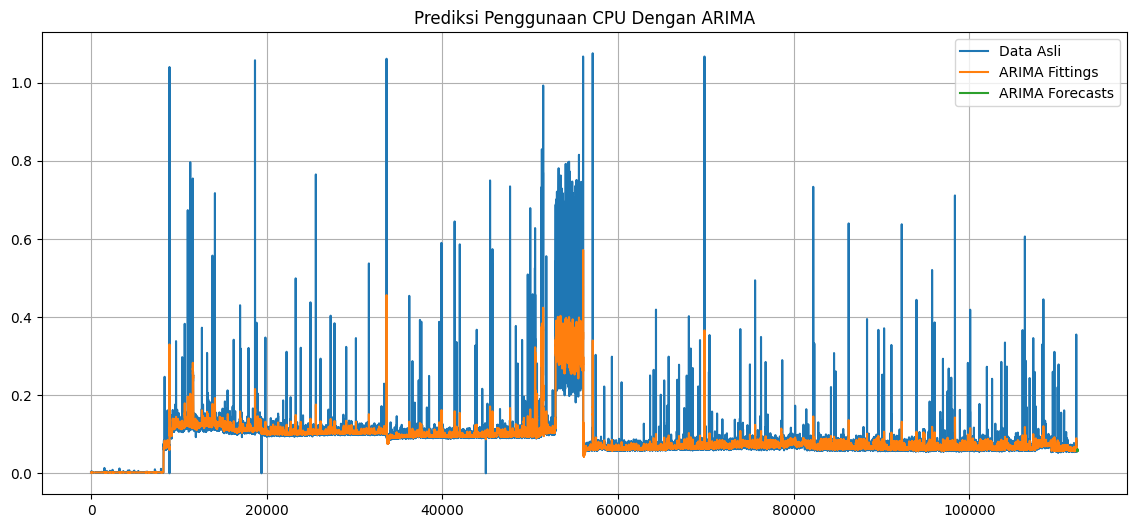

In [39]:
fig, ax = plt.subplots(1,1,figsize=(14,6))

ax.plot(np.arange(1,len(y_train)+1,1), 
           y_train[:len(y_train)], 
           label='Data Asli')

ax.plot(np.arange(1,len(y_train)+1,1), 
           fitting, 
           label='ARIMA Fittings')

ax.plot(np.arange(len(y_train),len(y_train)+(prediction_days * 24),1), 
           predictions, 
           label='ARIMA Forecasts')

plt.title('Prediksi Penggunaan CPU Dengan ARIMA')
plt.grid()
plt.legend()